# Contenido
* [Casos totales](#1.)
* [Nuevos casos](#2.)

In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters

import numpy as np
import datetime
import os
import sys

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
register_matplotlib_converters()

from scipy.optimize import curve_fit
from datetime import timedelta
from datetime import datetime
from io import StringIO
from urllib import request as url_request

In [2]:
days_past = -2 # days beyond the start of the data to plot
days_future = 20 # days after the end of the data to predict and plot

myFmt = mdates.DateFormatter('%d/%m') # date formatter for matplotlib
show_every = 2 # int value that defines how often to show a date in the x axis.

coeff_std = 1.1 # coefficient that defines how many standard deviations to use
coeff_std_d = 0.4

In [3]:
## Code from https://github.com/LucaAngioloni/fit-COVID19
def logistic(x, L, k, x0, y0):
    """
    General Logistic function.

    Args:
        x    float or array-like, it represents the time
        L    float, the curve's maximum value
        k    float, the logistic growth rate or steepness of the curve.
        x0   float, the x-value of the sigmoid's midpoint
        y0   float, curve's shift in the y axis
    """
    y = L / (1 + np.exp(-k*(x-x0))) + y0
    return y


## Defining functions. 
#### Code from https://github.com/LucaAngioloni/fit-COVID19

In [4]:
## Code from https://github.com/LucaAngioloni/fit-COVID19
def logistic_derivative(x, L, k, x0):
    """
    General Gaussian like function (derivative of the logistic).

    Args:
        x    float or array-like, it represents the time
        L    float, the curve's integral (area under the curve)
        k    float, the logistic growth rate or steepness of the curve.
        x0   float, the x-value of the max value
    """
    y = k * L * (np.exp(-k*(x-x0))) / np.power(1 + np.exp(-k*(x-x0)), 2)
    return y

In [5]:
## Code from https://github.com/LucaAngioloni/fit-COVID19
def fit_curve(curve, ydata, title, ylabel, last_date, coeff_std):
    xdata = np.array(list(range(-len(ydata), 0))) + 1

    if curve.__name__ == 'logistic':
        p0=[20000, 0.5, 1, 0]
        bounds=([0, 0, -100, 0], [200000, 10, 100, 1])
        params_names = ['L', 'k', 'x0', 'y0']
    elif curve.__name__ == 'logistic_derivative':
        p0=[20000, 0.5, 1]
        bounds=([0, 0, -100], [200000, 10, 100])
        params_names = ['L', 'k', 'x0']
    else:
        print('this curve is unknown')
        return -1

    popt, pcov = curve_fit(curve, xdata, ydata, p0=p0, bounds=bounds)

    descr = 'Fit parameters: '
    
    for i, param in enumerate(params_names):
        descr = descr + "{}={:.3f}".format(param, popt[i])
        if i < len(params_names) - 1:
            descr = descr + ', '
    print(descr)

    perr = np.sqrt(np.diag(pcov))
    print(perr)

    pworst = popt + coeff_std*perr
    pbest = popt - coeff_std*perr

    fig, ax = plt.subplots(figsize=(15,8))
    
    ax.xaxis.set_major_formatter(myFmt)
    fig.autofmt_xdate()

    total_xaxis = np.array(list(range(-len(ydata) + days_past, days_future))) + 1

    date_xdata = [last_date + timedelta(days=int(i)) for i in xdata]
    date_total_xaxis = [last_date + timedelta(days=int(i)) for i in total_xaxis]

    future_axis = total_xaxis[len(ydata) - days_past:]
    date_future_axis = [last_date + timedelta(days=int(i)) for i in future_axis]
    
    start = (len(ydata) - days_past - 1) % show_every


    ax.plot(date_total_xaxis, curve(total_xaxis, *popt), 'r-', linewidth=6, label='fit')
    ax.bar(date_xdata, ydata, label='data')
    ax.fill_between(date_future_axis, curve(future_axis, *pbest), curve(future_axis, *pworst), 
        facecolor='red', alpha=0.2, label='std')
    
    ax.set_xticks(date_total_xaxis[start::show_every])
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    ax.set_title(title + ' - ' + str(last_date.strftime("%d-%m-%Y")))
    ax.legend(loc='upper left')
    ax.grid(True)

    return popt, perr

## Reading data

In [6]:
data = pd.read_csv('../data/final_data/dataCOVID19_es.csv')
Spain = data.groupby('fecha', as_index=False).sum()

In [7]:
Confirmed=Spain.casos.values
Deaths=Spain.muertes.values
nuevos_casos = [np.nan]+list(Spain.casos.values[1:] - Spain.casos.values[:-1])

dates=pd.to_datetime(Spain.fecha.values)

last_date = datetime.strptime(Spain.fecha.values[-1], "%Y-%m-%d")

# Total confirmed cases <a class="anchor" id="1."></a>

Fit parameters: L=76898.883, k=0.259, x0=-0.088, y0=0.000
[9.33755057e+03 1.55508943e-02 8.55684974e-01 2.56929023e+02]


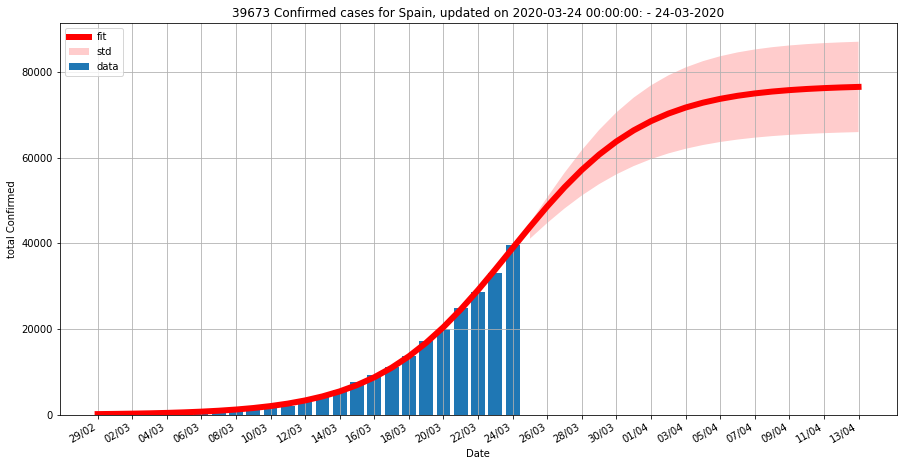

In [8]:
Titulo = '{:.0f} Confirmed cases for Spain, updated on {}:'.format(Confirmed[-1],dates[-1])
p_cont, err_cont = fit_curve(logistic, Confirmed, Titulo , 'total Confirmed', last_date, coeff_std);

Number of deaths 2696


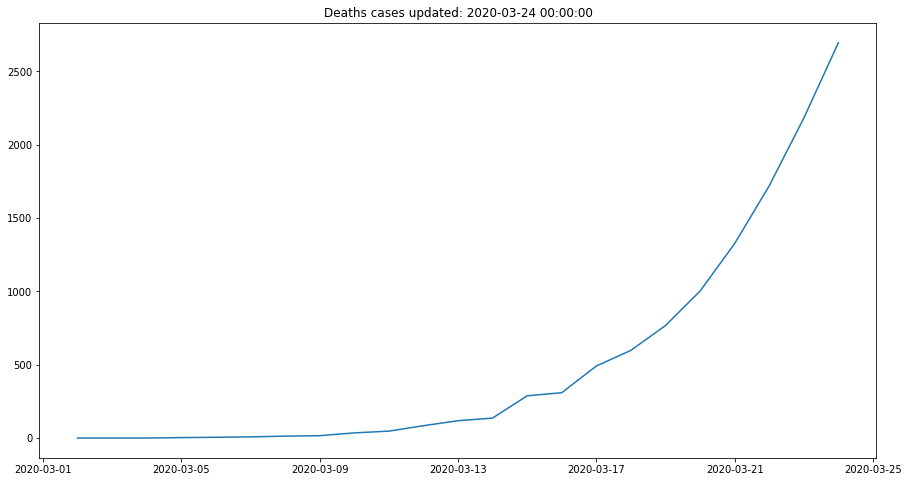

In [9]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(dates,Deaths)
ax.set_title("Deaths cases updated: {}".format(dates[-1]));
print('Number of deaths {:.0f}'.format(Deaths[-1]))

Fit parameters: L=7745.765, k=0.314, x0=1.999, y0=0.000
[1.18428527e+03 1.33067134e-02 7.98163575e-01 9.14092956e+00]


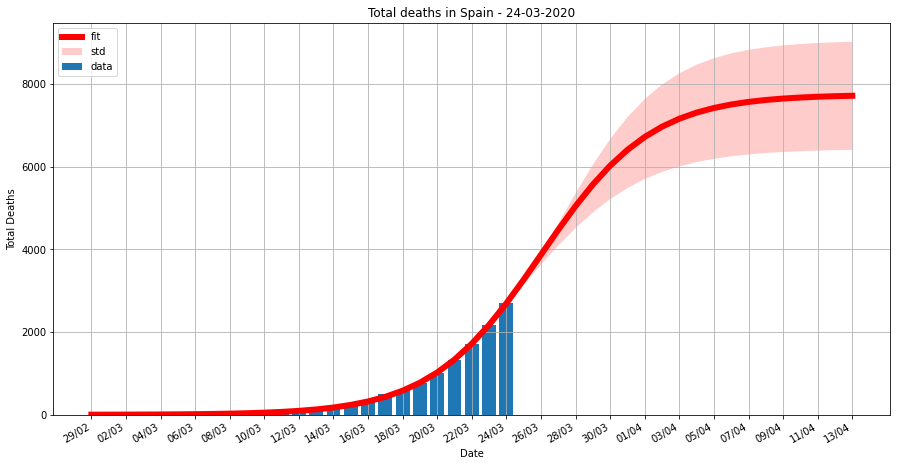

In [10]:
p_dead, err_dead = fit_curve(logistic, Deaths, 'Total deaths in Spain', 'Total Deaths', last_date, coeff_std)

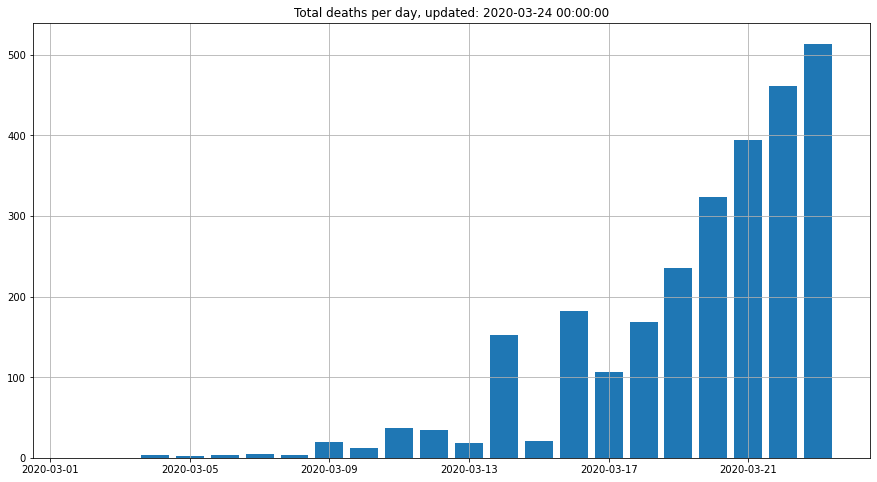

In [11]:
fig, ax = plt.subplots(figsize=(15,8))
ax.bar(dates[:-1],np.diff(Deaths))
ax.set_title("Total deaths per day, updated: {}".format(dates[-1]));
ax.grid()

# Nuevos casos <a class="anchor" id="2."></a>

## En toda España

Fit parameters: L=200000.000, k=0.192, x0=7.562
[1.87638683e+05 4.00764956e-02 7.36857205e+00]


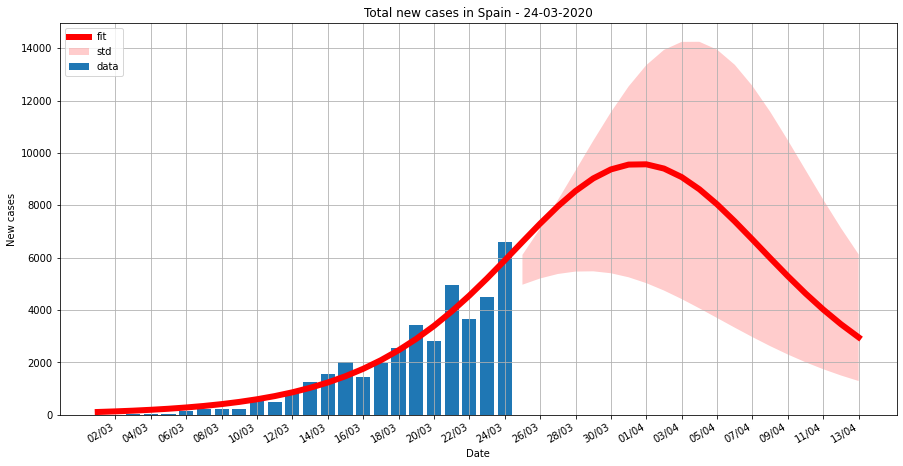

In [12]:
newCases=np.diff(Confirmed)

Titulo = '{:.0f} new cases for Spain, updated on {}:'.format(newCases[-1],dates[-1])
fit_curve(logistic_derivative, newCases, 'Total new cases in Spain', 'New cases', last_date, coeff_std_d);

In [13]:
tempVar=np.diff(Confirmed)
tempVar[tempVar==0]=np.nan
newCases=tempVar
datesNewCases=dates[1:]

In [14]:
growth_factor = newCases[1:] / newCases[:-1]
dates_growth_factor = datesNewCases[1:]

### Growth rates in Spain

In [15]:
print('Last growth factor: {:.3f}'.format(growth_factor[-1]))
print('Mean growth factor for the last 5 days: {:.3f}'.format(np.mean(growth_factor[-5:])))

Last growth factor: 1.458
Mean growth factor for the last 5 days: 1.201


### nuevos casos por CCAA ajustados a una logistic curve

Fit parameters: L=199999.954, k=0.175, x0=25.327
[6.97044033e+06 7.44168412e-02 2.11584913e+02]
Fit parameters: L=3806.548, k=0.215, x0=6.895
[5.55841658e+03 6.81150018e-02 1.01902808e+01]
Fit parameters: L=883.108, k=0.341, x0=-2.479
[2.02074439e+02 8.79650048e-02 1.12476326e+00]
Fit parameters: L=977.395, k=0.325, x0=0.641
[3.86251344e+02 8.33300391e-02 2.16037688e+00]
Fit parameters: L=3783.108, k=0.289, x0=-0.687
[1.20329449e+03 7.68895578e-02 1.95136157e+00]
Fit parameters: L=1100.950, k=0.272, x0=0.540
[2.08328746e+02 3.44397485e-02 1.23365769e+00]
Fit parameters: L=555.213, k=0.554, x0=-1.196
[77.52724868  0.08503291  0.42592337]
Fit parameters: L=4504.653, k=0.327, x0=0.113
[1.49788568e+03 7.95693493e-02 1.80855469e+00]
Fit parameters: L=4685.518, k=0.310, x0=0.098
[8.99300202e+02 4.35453510e-02 1.10046867e+00]
Fit parameters: L=200000.000, k=0.248, x0=13.393
[2.01924706e+06 9.32646506e-02 4.68492929e+01]
Fit parameters: L=1.717, k=9.321, x0=-4.000
[ 29.50891514 160.23820886  1

/Users/pvb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':
/Users/pvb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in multiply
  if sys.path[0] == '':
/Users/pvb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in power
  if sys.path[0] == '':
/Users/pvb/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


Fit parameters: L=37646.791, k=0.163, x0=4.303
[3.80606472e+04 7.12885508e-02 1.04527615e+01]
Fit parameters: L=25.409, k=0.825, x0=-6.929
[5.62276373 0.22520722 0.4720156 ]
Fit parameters: L=590.726, k=0.318, x0=-1.432
[9.21858021e+01 4.79569415e-02 8.53840248e-01]
Fit parameters: L=1965.531, k=0.239, x0=-0.063
[5.47759780e+02 4.92422151e-02 2.07103397e+00]
Fit parameters: L=4798.842, k=0.276, x0=-0.267
[1.33847698e+03 5.96820508e-02 1.79435528e+00]


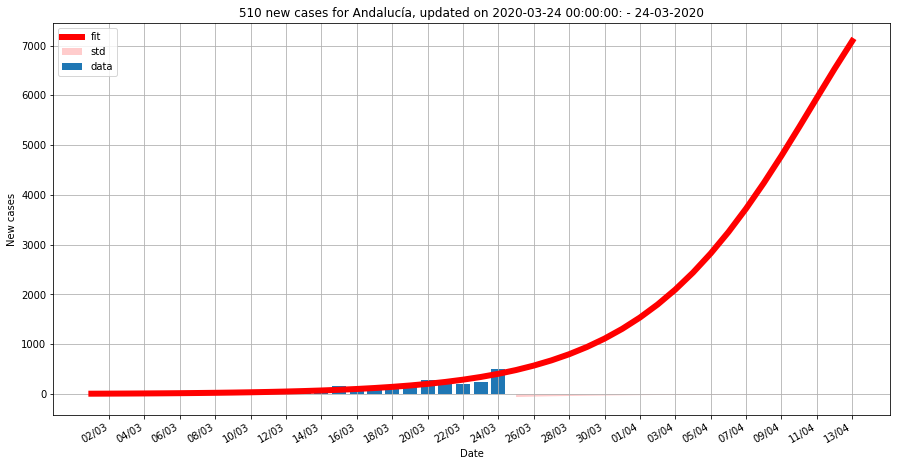

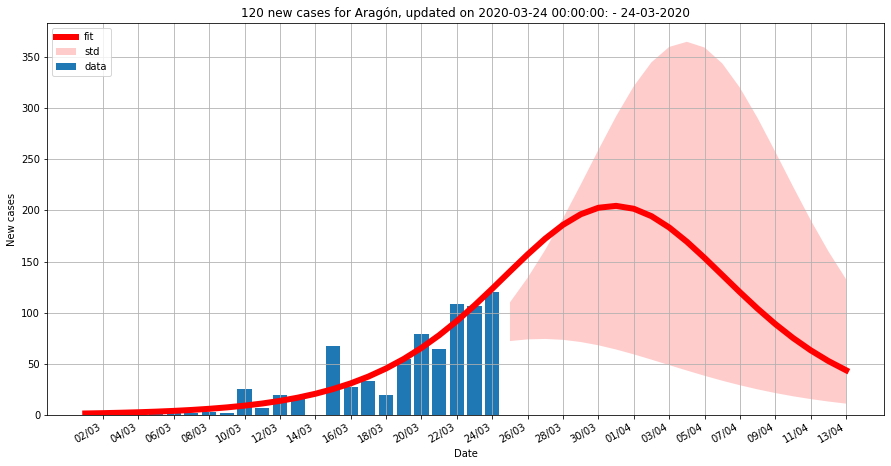

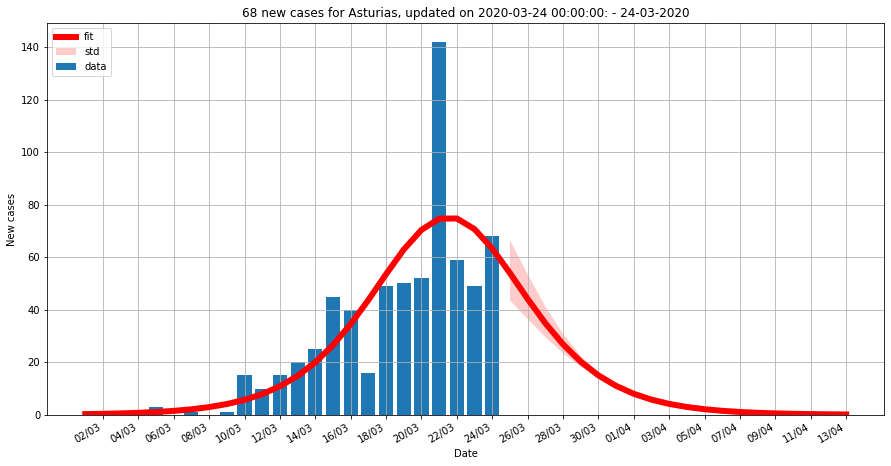

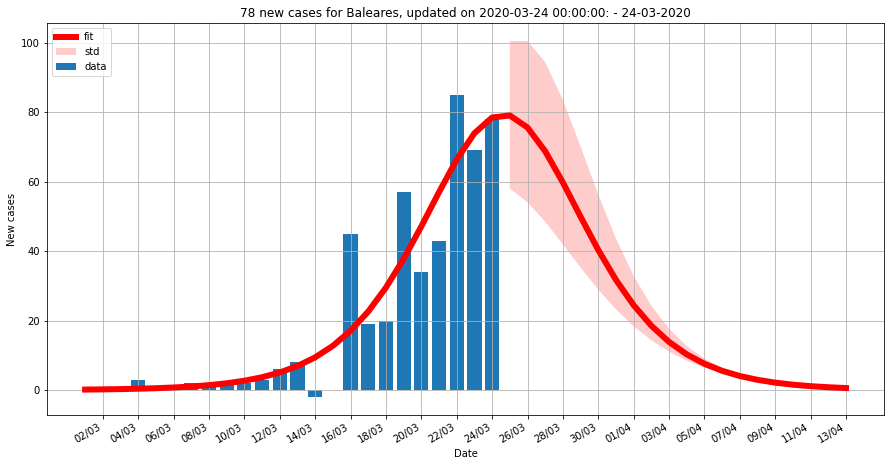

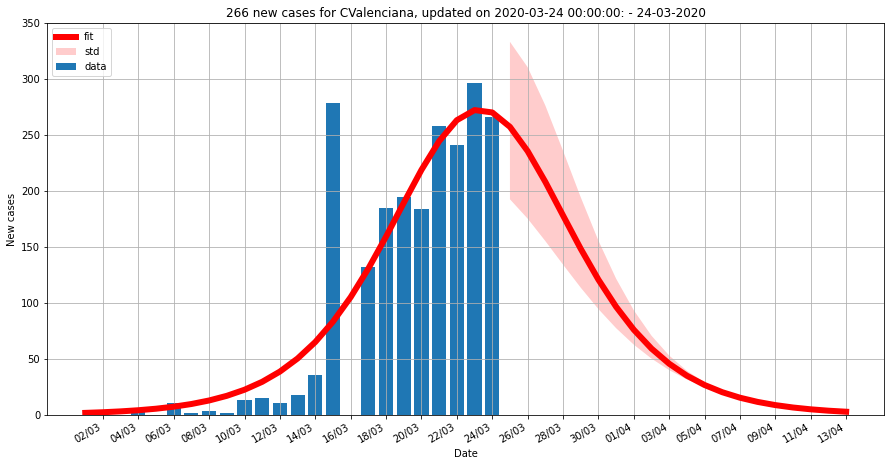

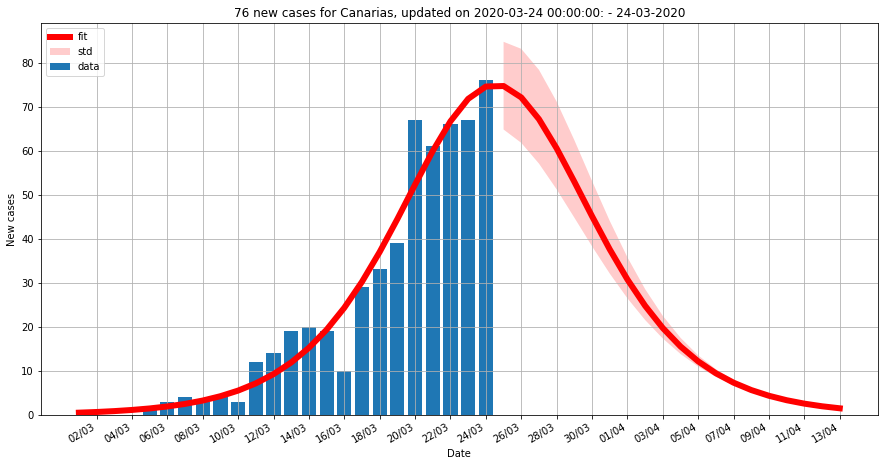

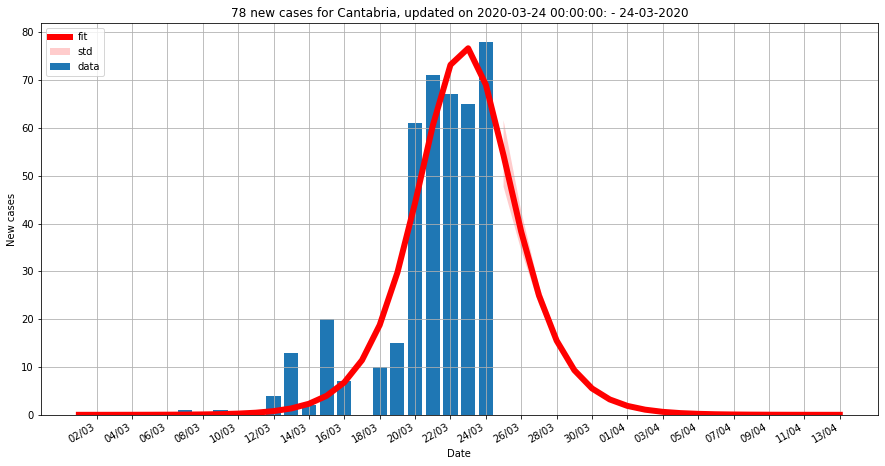

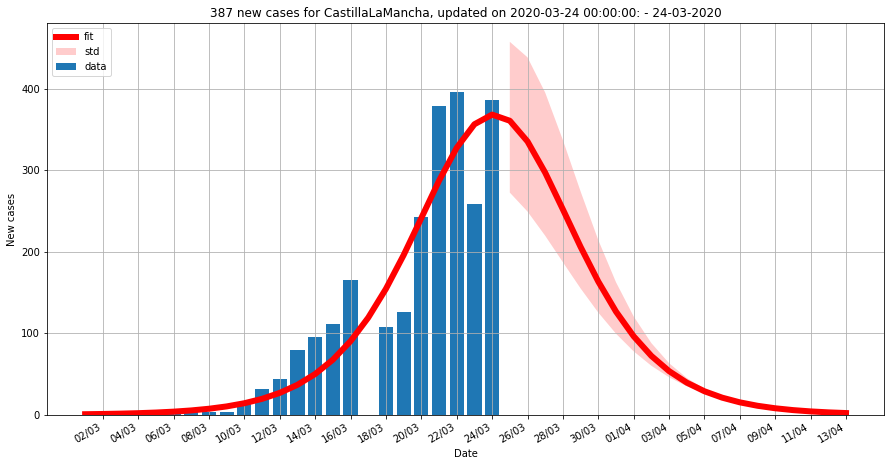

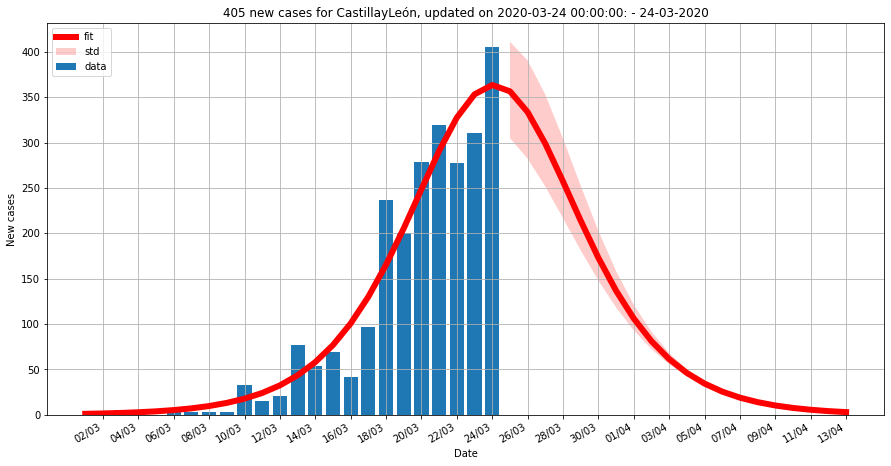

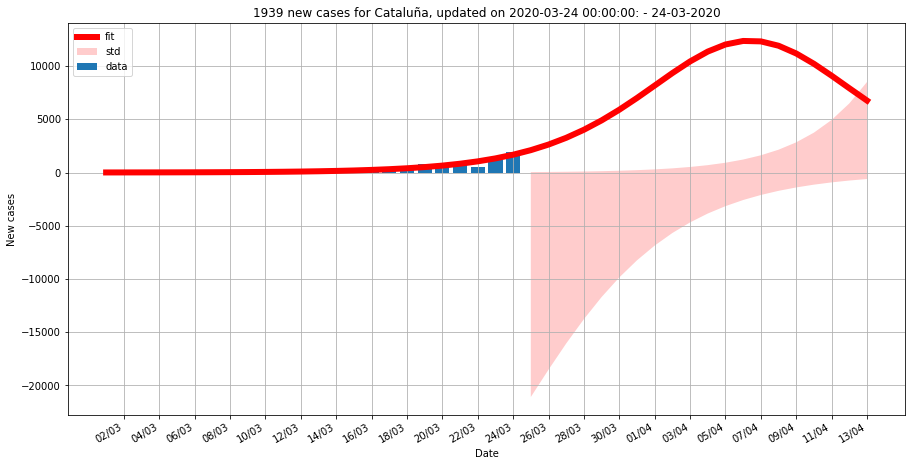

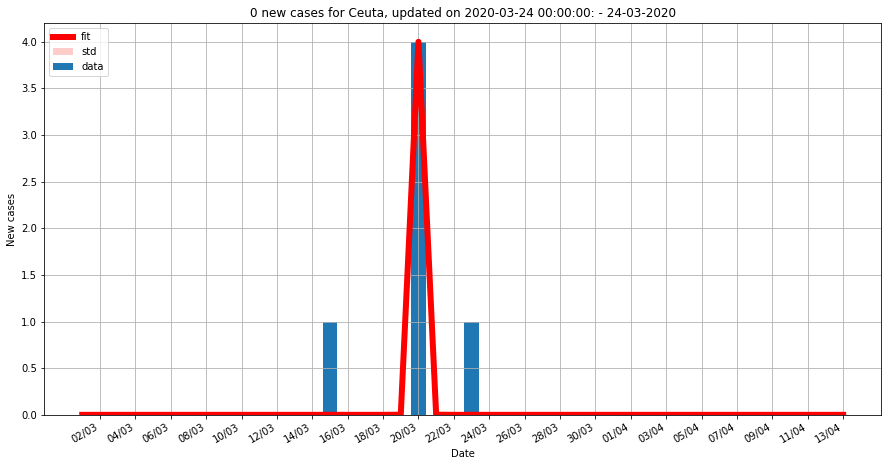

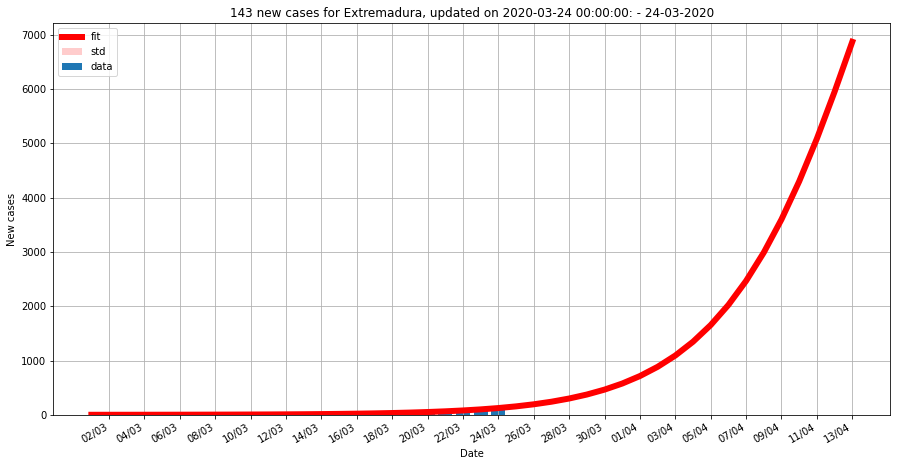

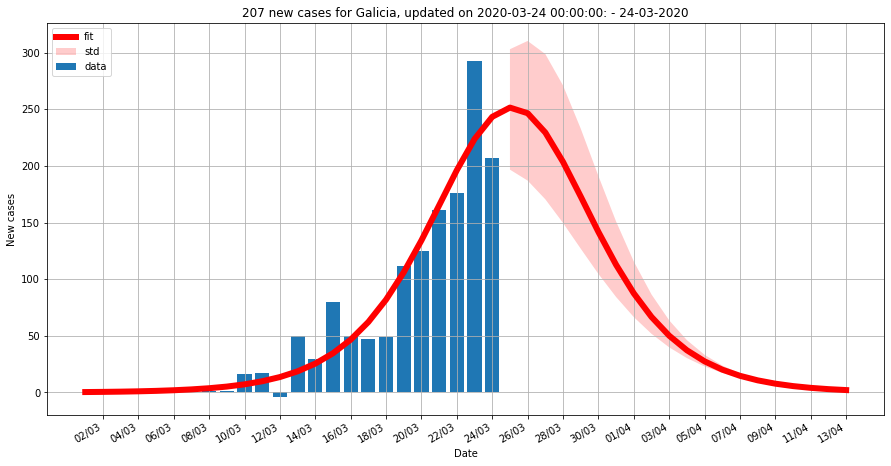

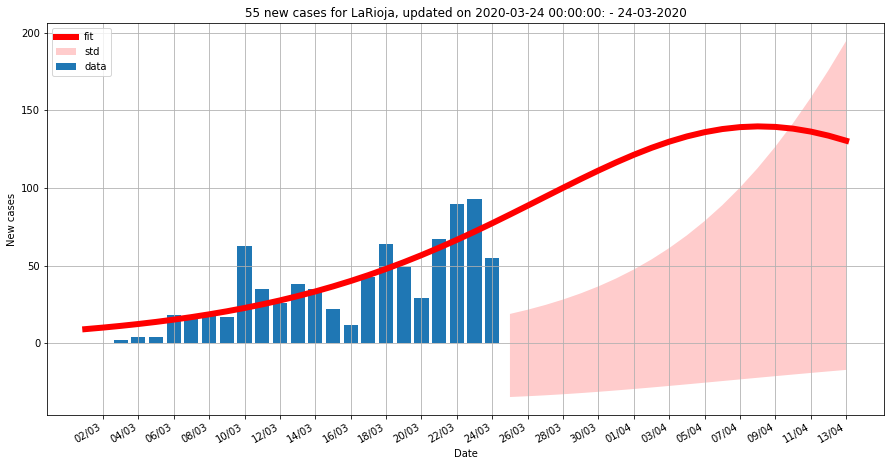

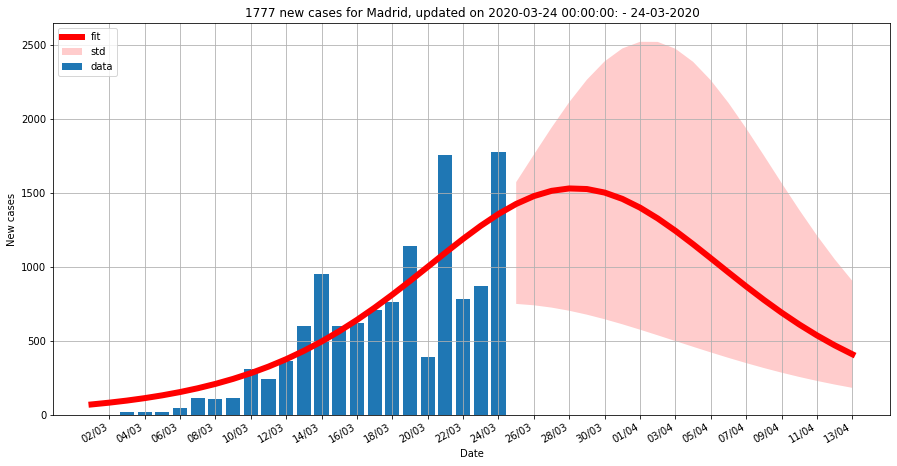

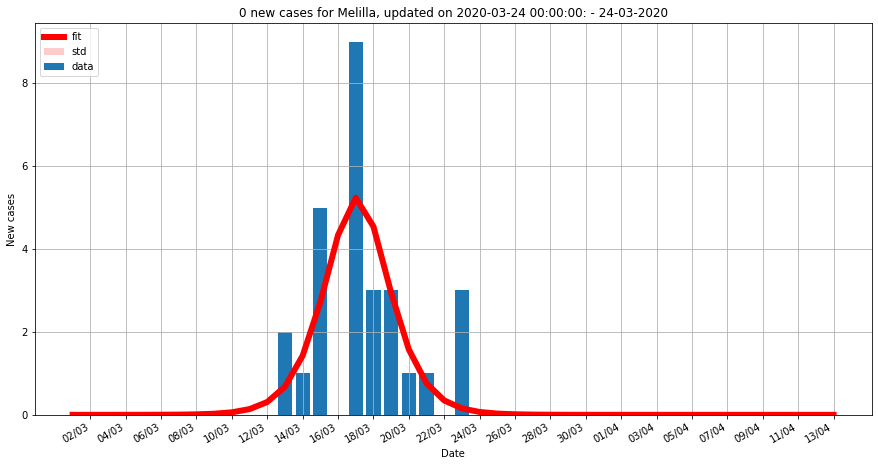

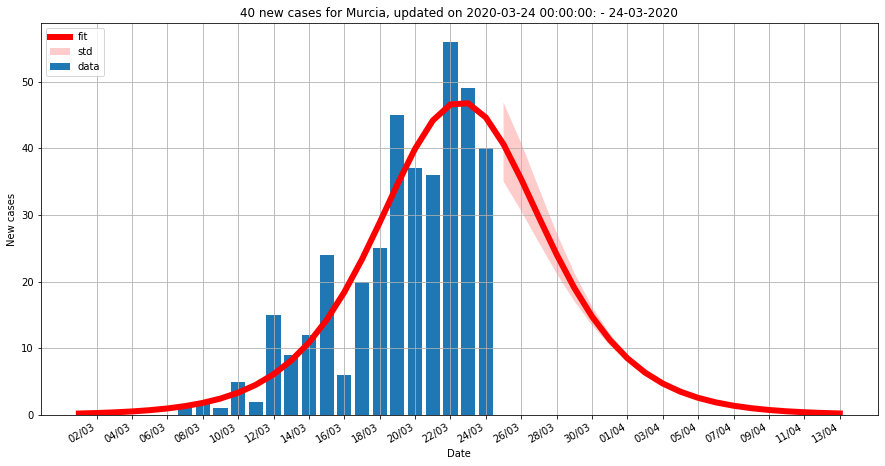

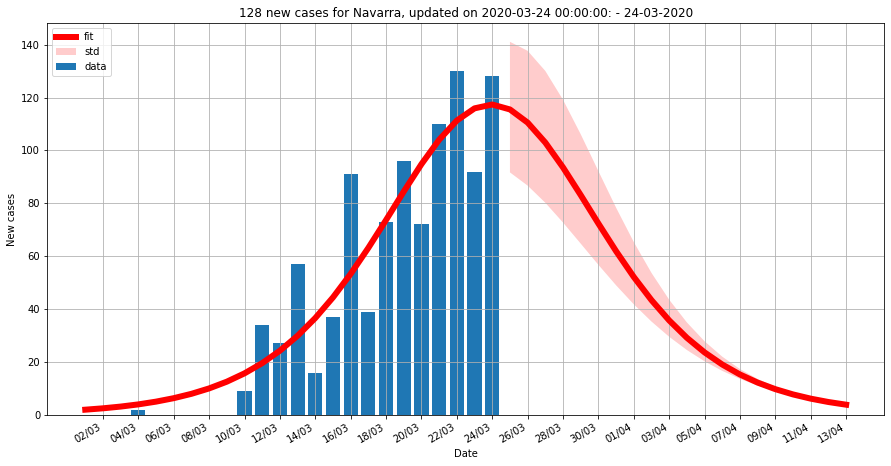

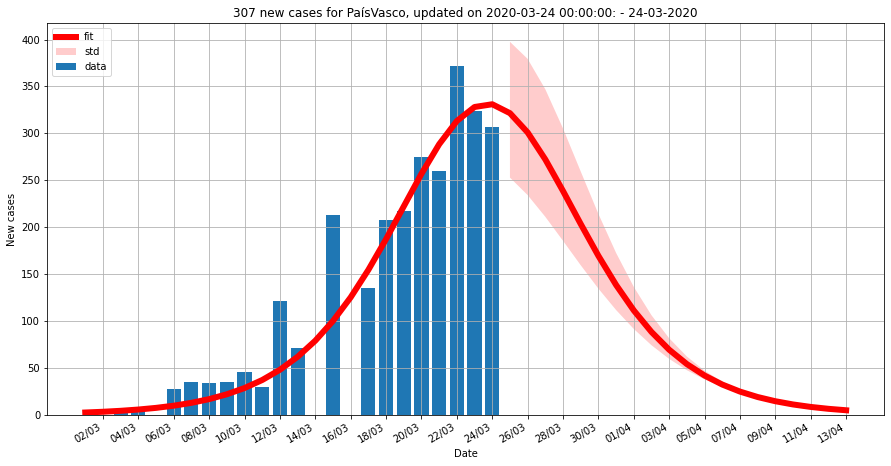

In [16]:
for CCAA in data.CCAA.unique():
    newCasesCCAA = np.diff(data[data.CCAA==CCAA].casos.values)
    Titulo = '{:.0f} new cases for {}, updated on {}:'.format(newCasesCCAA[-1],CCAA,dates[-1])
    fit_curve(logistic_derivative, newCasesCCAA, Titulo, 'New cases', last_date, coeff_std_d);